# Demo: empirical analysis of CVaR-based learning

This demo covers the numerical tests of learning algorithms driven by CVaR-based feedback done in the following paper.

- Learning with risk-averse feedback under potentially heavy tails (cf. Sections 2.3 and 3). Matthew J. Holland and El Mehdi Haress. AISTATS 2021.

The contents of this demo notebook are as follows:

- <a href="#guide">Guide to running the experiments</a>
- <a href="#prelim">Visualize: preliminaries</a>
- <a href="#multitrial">Visualize: aggregation over multiple trials</a>

First we give some details describing how to actually run the tests on your machine. The remainder of the demo aids the user in visualizing the test results after the experiments have actually been run.


___

<a id="guide"></a>
## Guide to running the experiments

A high-level description of the full procedure involved in running these experiments is given in the README file of this repository. We assume the user has already covered sections "Setup: preparing the benchmark data sets" and "Setup: software for tests using benchmark data" from the main README file. As such, all that remains to be done here is to fill in the details related to experiment parameter settings.


### Glossary of experimental parameters

- `--algo-ancillary`: specifies the underlying learning algorithm to use (e.g., SGD); call these the *ancillary iterates*.
- `--algo-main`: lets us specify an additional procedure to operate on the ancillary iterates (e.g., do nothing or average SGD iterates, etc.); call these the *main iterates*.
- `--batch-size`: size of mini-batch to use.
- `--data`: the name of the data set to be used.
- `--entropy`: used when we want to ensure all methods are tested on the same pseudo-randomly generated/shuffled datasets.
- `--loss`: the name of the loss function to be used.
- `--model`: the name of the model to be used.
- `--num-epochs`: the number of passes to make over the training data.
- `--num-procs` (*only in* `learn_rb_run.sh`): control the number of independent sub-processes to be run.
- `--num-trials`: the number of randomized trials to be run.
- `--step-size`: global step-size coefficient (multiplies the step-size computed internally by algorithms).
- `--task-name`: mostly for clerical purposes, when we want to distinguish results for different setups etc.


### Detailed parameter settings

The experiments given in our AISTATS 2021 paper are computed using a combination of the following experimental parameter settings:

- `--algo-ancillary`: `"SGD"` or `"RGD-M"`.
- `--algo-main`: `""` or `"Ave"`.
- `--batch-size`: `"0"` (full batch) or `"1"`.
- `--data`: `"ds_lognormal"`, `"ds_normal"`, or `"ds_pareto"`.
- `--loss`: `"absolute"` or `"quadratic"`.
- `--model`: `"linreg"`.
- `--num-epochs`: `"40"`.
- `--num-procs`: `"10"` (for `learn_rb_run.sh` only).
- `--num-trials`: `"100"`.
- `--step-size`: `"0.1"` or `"0.01"`.
- `--task-name`: `"default"`.

In particular, using the nomenclature from the paper as-is, we get __RGD-M__ and __ERM-GD__ by running `learn_run.sh` with the appropriate settings (as specified in the paper), and we get __RV-SGDAve__ by similarly running `learn_rb_run.sh`.


### Execution

If the shell script(s) `learn*_run.sh` have been appropriately modified to reflect any of the above settings, then running the experiments is a one-line operation.

__For procedures *without* robust boosting:__

```
(robrisk) $ ./learn_run.sh
```

__For procedures *with* robust boosting:__

```
(robrisk) $ ./learn_rb_run.sh
```

Once the tests have been run, a collection of raw experimental results should be written to disk. The following section covers the tasks of processing and visualizing these results.

___

<a id="prelim"></a>
## Visualize: preliminaries

In [1]:
## External modules.
from contextlib import ExitStack
import json
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, MultipleLocator
import numpy as np
import os

## Internal modules.
from mml.utils import makedir_safe
from setup_data import dataset_paras
from setup_results import img_dir, results_dir, my_fontsize, my_ext, export_legend


In [2]:
## Parameters to be set by the user.
task_name = "default" # specify task name
data = "ds_lognormal" # specify dataset name
model = "linreg" # specify model name
eval_type = "absolute_cvar" # specify evaluation metric (quadratic_cvar, absolute_cvar, quadratic, absolute)

In [3]:
## Helper function definition.
def agg_fn_all(arr, agg_type):
    if agg_type == "mean":
        return np.mean(arr, axis=0)
    elif agg_type == "sd":
        return np.std(arr, axis=0)
    else:
        raise ValueError

In [4]:
## Automated clerical setup.
fname_base = task_name+"-"+model
eval_train = eval_type+"_train"
eval_test = eval_type+"_test"

## Directory setup.
toread_dir = os.path.join(results_dir, data)
towrite_dir = os.path.join(img_dir)
makedir_safe(towrite_dir)

## Colour setup.
mth_cmap = cm.get_cmap("tab20")
mth_colours = []
for i in range(20):
    mth_colours += [mth_cmap.colors[i]]


___

<a id="multitrial"></a>
## Visualize: over multiple trials

In [5]:
## Set how we aggregate over trials.
agg_todo = "mean" # "mean", "sd"
agg_fn = lambda array: agg_fn_all(arr=array, agg_type=agg_todo)

In [6]:
## A few lines of code to extract all the method names.
all_files = os.listdir(toread_dir)
names_raw = []
for s in all_files:
    split_hyphen = s.split("-")
    split_dot = s.split(".")
    if split_hyphen[0] == task_name and split_dot[-1] != "json":
        names_raw += ["-".join(split_hyphen[0:-1])]
names_raw = np.array(names_raw)
names_unique = np.unique(names_raw)
print("Unique names found:", names_unique)

Unique names found: ['default-linreg_RGD-M' 'default-linreg_SGD' 'default-linreg_SGD_Ave'
 'default-linreg_rb_SGD_Ave']


In [7]:
to_plot_names = {fname_base+"_"+"RGD-M": "RGD-M",
                 fname_base+"_"+"SGD": "ERM-GD",
                 fname_base+"_"+"rb_SGD_Ave": "RV-SGDAve",
                 fname_base+"_"+"SGD_Ave": "SGDAve"}
to_plot = [fname_base+"_"+"RGD-M",
           fname_base+"_"+"SGD",
           fname_base+"_"+"rb_SGD_Ave",
           fname_base+"_"+"SGD_Ave"]
to_plot_colours = {a: mth_colours[j] for j, a in enumerate(to_plot)}

In [8]:
## Gathering of results.
dict_train = {a: [] for a in to_plot}
dict_test = {a: [] for a in to_plot}

for mth_name in to_plot:
    
    trial = 0
    do_gathering = True
    
    while do_gathering:
        
        toread_train = os.path.join(
            toread_dir, ".".join([mth_name+"-"+str(trial), eval_train])
        )
        toread_test = os.path.join(
            toread_dir, ".".join([mth_name+"-"+str(trial), eval_test])
        )
        
        with ExitStack() as stack:
            
            try:
                f_train = stack.enter_context(open(toread_train, mode="r", encoding="ascii"))
                yvals = np.loadtxt(fname=f_train, dtype=np.float,
                                   delimiter=",", ndmin=2)
                dict_train[mth_name] += [yvals]
            except FileNotFoundError:
                do_gathering = False
                print("({}) Finished collecting training results.".format(mth_name))
                
            try:
                f_test = stack.enter_context(open(toread_test, mode="r", encoding="ascii"))
                yvals = np.loadtxt(fname=f_test, dtype=np.float,
                                   delimiter=",", ndmin=2)
                dict_test[mth_name] += [yvals]
            except FileNotFoundError:
                print("({}) Finished collecting test results.".format(mth_name))
        
        ## If the current trial went through, increment to try the next one.
        if do_gathering:
            trial += 1
            
dict_train = {a:np.hstack(dict_train[a]).T for a in dict_train.keys()}
dict_test = {a:np.hstack(dict_test[a]).T for a in dict_test.keys()}

(default-linreg_RGD-M) Finished collecting training results.
(default-linreg_RGD-M) Finished collecting test results.
(default-linreg_SGD) Finished collecting training results.
(default-linreg_SGD) Finished collecting test results.
(default-linreg_rb_SGD_Ave) Finished collecting training results.
(default-linreg_rb_SGD_Ave) Finished collecting test results.
(default-linreg_SGD_Ave) Finished collecting training results.
(default-linreg_SGD_Ave) Finished collecting test results.


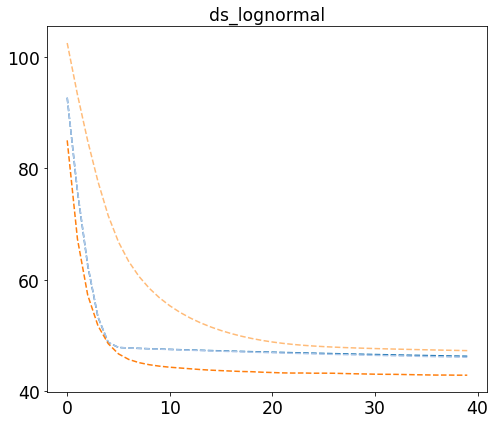

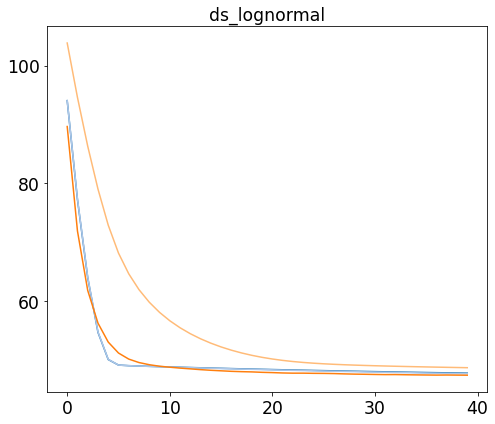

In [9]:
## Visualization of results.

fig, ax = plt.subplots(1, 1, figsize=(7,6)) # bigger size for detailed viewing.
for j, mth_name in enumerate(dict_train.keys()):
    yval_array = dict_train[mth_name]
    num_trials, num_epochs = yval_array.shape
    yvals = agg_fn(yval_array)
    xvals = np.arange(num_epochs)
    ax.plot(xvals, yvals,
            color=to_plot_colours[mth_name],
            label="{} tr".format(to_plot_names[mth_name]),
            ls="--")
ax.tick_params(labelsize=my_fontsize)
#ax.legend(loc=0, ncol=2, fontsize=my_fontsize)
ax.set_title("{}".format(data),
             size=my_fontsize)
fname = os.path.join(towrite_dir, "{}_{}_{}_tr.{}".format(eval_type, agg_todo,
                                                       data, my_ext))
ax.xaxis.set_major_locator(MultipleLocator(10))
#ax.yaxis.set_major_formatter("{x:.1f}")
ax.yaxis.set_major_locator(MaxNLocator(4))
plt.tight_layout()
#plt.savefig(fname=fname)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(7,6)) # bigger size for detailed viewing.
for j, mth_name in enumerate(dict_test.keys()):
    yval_array = dict_test[mth_name]
    num_trials, num_epochs = yval_array.shape
    yvals = agg_fn(yval_array)
    xvals = np.arange(num_epochs)
    ax.plot(xvals, yvals,
            color=to_plot_colours[mth_name],
            label="{} te".format(to_plot_names[mth_name]),
            ls="-")
ax.tick_params(labelsize=my_fontsize)
#ax.legend(loc=0, ncol=2, fontsize=my_fontsize)
ax.set_title("{}".format(data),
             size=my_fontsize)
fname = os.path.join(towrite_dir, "{}_{}_{}_te.{}".format(eval_type, agg_todo,
                                                       data, my_ext))
ax.xaxis.set_major_locator(MultipleLocator(10))
#ax.yaxis.set_major_formatter("{x:.1f}")
ax.yaxis.set_major_locator(MaxNLocator(4))
plt.tight_layout()
#plt.savefig(fname=fname)
plt.show()

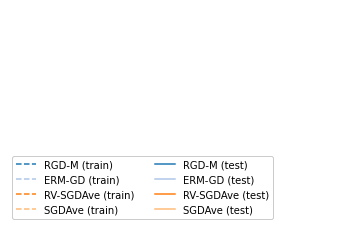

In [10]:
## Legends.

labels = [to_plot_names[a]+" (train)" for a in to_plot] + [to_plot_names[a]+" (test)" for a in to_plot]
colours = [to_plot_colours[a] for a in to_plot] + [to_plot_colours[a] for a in to_plot]
linestyles = ["--"]*len(to_plot_names) + ["-"]*len(to_plot_names)

f = lambda m,c,l: plt.plot([],[],marker=m, color=c, ls=l)[0]
handles = [f(None, colours[i], linestyles[i]) for i in range(len(labels))]
legend = plt.legend(handles, labels, loc=3, ncol=2, framealpha=1, frameon=True)
fname = os.path.join(towrite_dir, "legend.{}".format(my_ext))
export_legend(legend=legend, filename=fname)
plt.show()

___